# Quantum kernel methods using linear optics

This notebook follows closely the theory and implementation of Yin et al, "Experimental quantum-enhanced kernels on a photonic processor," *arXiv*, 2024. https://arxiv.org/abs/2407.20364 [1].

Kernel methods are a class of algorithm in machine learning used for classification, clustering and regression. These methods exploit feature maps which project a dataset of interest to a higher-dimensional space. For classification tasks, the data is then linearly separable by a hyperplane in the new space. 

![Feature map transformation](../_static/img/kernel_transformation.png)

Behind kernel methods is the kernel trick where the mapping is not explicitly calculated. Instead, the inner product between feature vectors is evaluated for each pair of points.
$$0 \leq \kappa(x_{i}, x_{j}) \leq 1$$

For pairwise datasets, $x$ and $x'$, these inner products can be contained in the kernel matrix:
$$ K_{i, j} = \kappa(x_{i}, x_{j}') = \kappa(x_{j}', x_{i}) $$

In quantum kernel methods, we often consider the fidelity-based quantum kernel, which for an input feature map $U(x)$, is expressed as follows in the computational basis:
$$ \kappa(x_{i}, x_{j}) = |\langle \bm{0} | U^{\dagger}(x_i) U(x_j) | \bm{0} \rangle|^{2} $$

For identical input datasets, the kernel matrix is symmetric, positive-definite with 1s along the diagonal. Generally, we consider two types of kernel matrices. The symmetric training matrix in which the kernel matrix is constructed using two copies of the training set. And the test matrix in which the kernel matrix is constructed using the test set and the training set. For classification tasks, we can utilise a classical support vector machine whose parameters are optimised in order to linearly separate the data of interest.

In this notebook, we will simulate a photonic processor to estimate a fidelity-based kernel. We then use this kernel function to classify an ad-hoc binary dataset.

In [ ]:
# Perceval for linear optics simulation
from perceval import Circuit, BasicState, NoiseModel, Processor, PostSelect, pdisplay
from perceval.algorithm import Sampler
import perceval.components.unitary_components as comp

# Sci-kit learn for ML functionality
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Maths packages
import numpy as np
from scipy.linalg import sqrtm, inv

# Matplotlib for plotting graphs
import matplotlib.pylab as plt

# Pretty typing
from typing import Callable, Tuple

## Introduction

Firstly, we consider an $M$-mode linear interferometer described by the matrix, $U$. We note that the probability of obtaining an output state, $|\mathbf{t} \rangle = |t_1, t_2, \cdots , t_M \rangle$, for a given input state, $|\mathbf{s} \rangle = |s_1, s_2, \cdots , s_M \rangle$ is:
$$ |\langle \mathbf{s} | U | \mathbf{t} \rangle|^{2} = \frac{|\text{Per} \left( U_{s, t} (x, x') \right)|^2}{t_1! t_2! ... t_M!} $$

where $\text{Per}(U_{s, t})$ is the permanent of the matrix, $U_{s, t}$ which is constructed by repeating the $j^{th}$ column $t_{j}$ times, followed by repeating the $i^{th}$ row $s_{i}$ times [2]. First, we will define a function which will estimate the kernel associated with a given feature map, $U(x)$ and initial state, $| s \rangle.$ 
$$ \kappa^{(\mathbf{s})}(x, x') = |\langle \mathbf{s} | U^{\dagger}(x') U(x) | \mathbf{s} \rangle| ^ {2} = |\langle \mathbf{s} | U (x, x') | \mathbf{s} \rangle| ^ {2}$$

We consider two possible kernels with indistinguishable and distinguishable photons. In the case of indistinguishable photons, we have the "quantum kernel":
$$ \kappa^{(\mathbf{s})}_Q(x, x') = \frac{|\text{Per} \left( U_{s, s} (x, x') \right)|^2}{\mathbf{s}!} $$

where $\mathbf{s}! = s_1! s_2! \cdots s_M!$. We will also consider the kernel constructed using distinguishable photons. In this case, we have the classical "coherent kernel":
$$ \kappa_C^{(\mathbf{s})}(x, x') = \frac{\text{Per} \left( |U_{s, s} (x, x')|^{2} \right)}{\mathbf{s}!} $$

There exists an efficient classical algorithm to calculate the permanent $\text{Per} \left( |U_{s, s} (x, x')|^{2} \right)$ [3].

In experimental circumstances, the experimentalist may not have access to photon-number resolving (PNR) detectors. In this instance, we consider the "unbunching kernel" in which there is maximum 1 photon found in each mode. In this circumstance, we lose the commutative property of the kernel function and the kernel matrix is not symmetric, positive definite for identical input datasets. We will force the kernel matrix to be symmetric by projecting the upper triangular onto the lower triangular. We will also force this matrix to be positive definite by decomposing the matrix spectrally:
$$K = Q \Lambda Q^{T}$$
and setting the negative eigenvalues in $\Lambda$ to $0$. The kernel matrix is then reconstructed.

In [ ]:
def kernel(
    x1, x2: np.ndarray, 
    feature_map: Callable[[np.ndarray], Circuit], 
    input_state: BasicState, 
    indistinguishability: float = 1.0, 
    unbunching: bool = False, 
    nshots: int | None = None
) -> float:
    """
    Estimate the kernel associated with a given feature map.
    Args:
        x1, x2               : Data inputs
        feature_map          : Quantum circuit to perform feature map
        input_state          : Initial state quantum feature map is applied to.
        indistinguishability : Photon indistinguishability (Hong Ou Mandel)
        unbunching           : Specifies whether to not use PNR detectors
        nshots               : Number of circuit runs to estimate kernel
    Returns
        Scalar kernel value
    """
    # Compile circuit to estimate kernel
    U = feature_map(x1, adjoint=False)
    U_dag = feature_map(x2, adjoint=True)
    processor = Processor("SLOS", U.m)
    processor.add(0, U)
    processor.add(0, U_dag)
    processor.min_detected_photons_filter(input_state.n)
    processor.noise = NoiseModel(indistinguishability=indistinguishability)
    
    if unbunching:
        # Add postselection so that there is max 1 photon in each mode
        postselect_rule = ' & '.join([f'[{mode}] < 2' for mode in range(processor.m)])
        postselection = PostSelect(postselect_rule)
        processor.set_postselection(postselection)
    
    # Apply settings to processor
    processor.with_input(input_state)
    processor.min_detected_photons_filter(input_state.n) 
    sampler = Sampler(processor)
    
    if nshots is None:
        # Exact probability calculation
        prob_distribution = sampler.probs()
        results = prob_distribution['results']
        overlap = results[input_state]
        return overlap
    else:
        # Estimated probability of input_state
        sample_count = sampler.sample_count(nshots)
        results = sample_count['results']
        overlap = results[input_state] / nshots
        return overlap

def kernel_matrix(X1, X2, feature_map, input_state, indistinguishability = 1.0,
                unbunching = False, nshots = None):
    """Estimates the kernel matrix associated with specified feature map and pairwise 
    datasets, X1, X2"""    
    matrix_symmetry = np.array_equal(X1, X2) 
    K = np.ones((len(X1), len(X2)))
    
    for i in range(len(X1)):
        # For symmetric matrix, calculate upper triangular only
        start_j = i + 1 if matrix_symmetry else 0 
        for j in range(start_j, len(X1)):
            if not np.array_equal(X1[i], X2[j]):
                K[i][j] = kernel(X1[i], X2[j], feature_map, input_state, indistinguishability, 
                                unbunching, nshots)
                if matrix_symmetry:
                    K[j][i] = K[i][j]
                
    # Make unbunching training matrix positive
    if unbunching and matrix_symmetry:
        eigenval, eigenvec = np.linalg.eig(K)
        K = (eigenvec @ np.diag(np.maximum(0, eigenval)) @ eigenvec.T).real
        np.fill_diagonal(K, 1)  # Ensure diagonals are equal to 1
    return K

We will consider an ad-hoc dataset in which the geometric difference between quantum and coherent kernel matrices is maximised. For a known unitary as feature map, Ref. [1] presents the following algorithm:
***
**Input** <br>
- Feature map, $U$ with $m$ modes, <br>
- Dataset size, $N$, <br>
- Feature dimension, <br>
- Number of input photons $d$, <br>
- Initial state $n$, <br> 
- $s \in \Phi_{m, n}$,<br>
- Regularisation parameter $\lambda \neq 0$<br>

***
1 &nbsp; Generate $N$ random datapoints, $\{x_i\}_{i=1}^{N}, x_i \in \mathbb{R}$ <br>
2 &nbsp; **while** $0 < i \leq N$ **do** <br>
3 &nbsp; &nbsp; &nbsp; **while** $0 < j \leq N$ **do** <br>
4 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $K_{Q}(x_i, x_j) \leftarrow |\text{per}\left(U(x_i, x_j) \right)|^{2}$ <br>
5 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $K_{C}(x_i, x_j) \leftarrow \text{per}\left(|U(x_i, x_j)|^{2}\right)$ <br>
6 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $K_{Q}(x_j, x_i) \leftarrow K_{Q}(x_i, x_j)$ <br>
7 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $K_{C}(x_j, x_i) \leftarrow K_{C}(x_i, x_j)$ <br>
8 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $ j \leftarrow  j + 1$ <br>
9 &nbsp; &nbsp; &nbsp; **end while** <br>
10 &nbsp; &nbsp; &nbsp; $i \leftarrow  i + 1$ <br>
11 &nbsp; **end while** <br>
12 &nbsp; $S \leftarrow \sqrt{K_Q} (K_C + \lambda \mathcal{I})^{-1} \sqrt{K_Q}$ <br>
13 &nbsp; $g \leftarrow$ max eigenvalue of $S$, $\mathbf{v}_{g} \leftarrow$ max eigenvector of $S$ <br>
14 &nbsp; $y \leftarrow \text{sign}(\sqrt{K_Q} \mathbf{\mathbf{v}_{g}})$
***


This algorithm allows one to generate a dataset in which the geometric distance between the quantum and coherent kernels is maximised.

In [3]:
def generate_data(
    feature_map: Callable[[np.ndarray], Circuit], 
    input_state: BasicState, 
    data_size: int, 
    data_dim: int, 
    reg: float
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates ad hoc dataset for choice of feature map and initial state.
    Args: 
        feature_map : Unitary to generate the dataset
        input_state : State on which the feature map acts on
        data_size   : Dataset size
        data_dim    : Feature dimension
        reg         : Regularization parameter
    Returns:
        Data features, Data labels
    """
    # Generate features dataset
    X = np.random.uniform(0, 2, size=(data_size, data_dim))

    # Construct quantum and coherent kernel matrices
    K_quantum = kernel_matrix(X, X, feature_map, input_state, indistinguishability=1)
    K_coherent = kernel_matrix(X, X, feature_map, input_state, indistinguishability=0)
    
    S = sqrtm(K_quantum) @ inv(K_coherent + reg * np.eye(data_size)) @ sqrtm(K_quantum)    
    eigenvals, eigenvecs = np.linalg.eig(S)
    v_g = eigenvecs[:, np.argmax(eigenvals)]
    vector = sqrtm(K_quantum) @ v_g
    
    # Assign labels
    y = np.where(np.real(vector) >= 0, 1, -1)
    return X, y

We will generate a feature map which encodes each component of a feature vector into the phase shifters of our linear optical set-up. Specifically, we let each pair of components be encoded into the phase shifters of a Mach-Zender interferometer (MZI): $\phi_i \rightarrow 2 \pi x_i$.

Each MZI is arranged in a brickwork pattern as shown in the figure below.

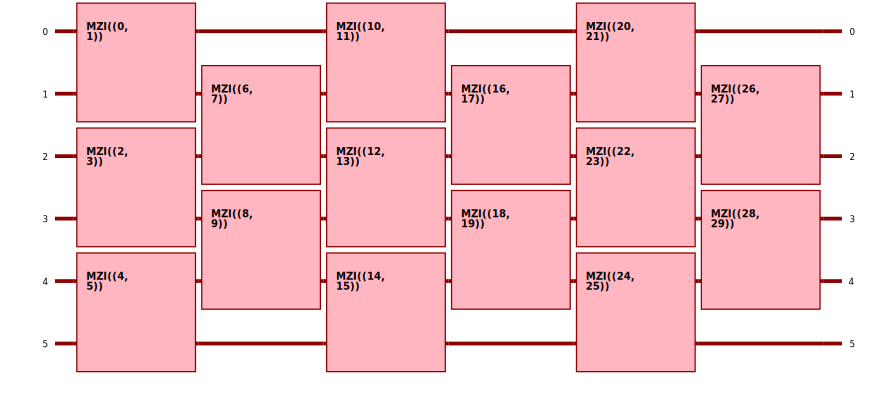

In [ ]:
def mach_zender(x1, x2):
    """Mach Zender interferometer with phase shifter values, 2pi x1 and 2pi x2"""
    # Calculate phase for phase shifter
    phi1 = (2 * np.pi * x1) % (2 * np.pi)
    phi2 = (2 * np.pi * x2) % (2 * np.pi)
    
    # Construct Mach Zender circuit
    MZI = Circuit(2, name=f'MZI({x1, x2})')
    MZI.add(0, comp.PS(phi1))
    MZI.add(0, comp.BS.H())
    MZI.add(0, comp.PS(phi2))
    MZI.add(0, comp.BS.H())
    return MZI

def brickwork(
    x: np.ndarray, 
    num_modes: int, 
    adjoint: bool = False
) -> Circuit:
    """Generates brickwork Mach-Zender feature map for input number of modes
    and input data.
    Args:
        x         : Data feature vector
        num_modes : Width of circuit
        adjoint   : Specifies whether feature map is adjoint or not
    Returns:
        Circuit
    """
    circ = Circuit(num_modes)
    even_modes = np.arange(0, num_modes - 1, 2)
    odd_modes = np.arange(1, num_modes - 1, 2)

    # sub_index determines which mode MZI is applied to
    sub_index = 0
    for i in range(0, len(x) - 1, 2):
        # Select modes based on the cycle position
        cycle_position = i // 2 % (num_modes - 1)
        modes = even_modes if cycle_position < num_modes // 2 else odd_modes
        
        # Add MZI to the appropriate mode
        circ.add(int(modes[sub_index]), mach_zender(x[i], x[i + 1]))
        
        # Reset index which MZI is applied to
        sub_index = (sub_index + 1) % len(modes)
    
    # Apply the adjoint unitary operator if specified
    if adjoint:
        circ.inverse(h=True)
    return circ

# Generate a sample brickwork circuit for input data x = [0, 1, ..., 29]
x = [i for i in range(30)]
num_modes = 6
pdisplay(brickwork(x, num_modes, adjoint=False))

## Training with Support Vector Classifiers

Let us generate our dataset of interest using this brickwork ansatz and split into training and test sets. As in Ref. [1], the dataset we will use is 30-dimensional, for which we generate 100 total datapoints.

In [ ]:
# Input parameters for data generation algorithm
N = 100
input_state = BasicState([1, 1, 0, 0])
reg = 0.02
feature_map = lambda x, adjoint : brickwork(x, input_state.m, adjoint)

X, y = generate_data(feature_map,
                    input_state,
                    data_size=N,
                    data_dim=30,
                    reg=reg,
                    )

Now pre-calculate the quantum kernel matrix for the total dataset. Here, we consider 1.0 indistinguishability and no unbunching.

In [9]:
K_Q = kernel_matrix(X, X, 
                    feature_map,
                    input_state, 
                    nshots=100_000,
                    indistinguishability=1.0,
                    )

Pre-calculate the coherent kernel matrix with 0.0 indistinguishability and no unbunching.

In [ ]:
K_C = kernel_matrix(X, X,
                    feature_map,
                    input_state,
                    nshots=100_000,
                    indistinguishability=0.0,
                    )

Now let's construct the unbunching kernel matrix with 1.0 indistinguishability and unbunching.

In [ ]:
K_U = kernel_matrix(X, X,
                    feature_map,
                    input_state,
                    nshots=100_000,
                    indistinguishability=1.0,
                    unbunching=True,
                    )

We will then split the X, y data into training and test sets. We allocate 2/3 of the datapoints to the training set, and 1/3 to the test set. 

In [ ]:
# Generate training and test indices to split matrices
indices = np.arange(N)
np.random.shuffle(indices)
split_point = int(N * 0.66)
train_indices = indices[:split_point]
test_indices = indices[split_point:]

# Train test split 
K_Q_train = np.array([[K_Q[i, j] for j in train_indices] for i in train_indices])
K_Q_test =  np.array([[K_Q[i, j] for j in train_indices] for i in test_indices])
K_C_train = np.array([[K_C[i, j] for j in train_indices] for i in train_indices])
K_C_test =  np.array([[K_C[i, j] for j in train_indices] for i in test_indices])
K_U_train = np.array([[K_U[i, j] for j in train_indices] for i in train_indices])
K_U_test =  np.array([[K_U[i, j] for j in train_indices] for i in test_indices])

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

Let's visualise the three different training and test matrices.

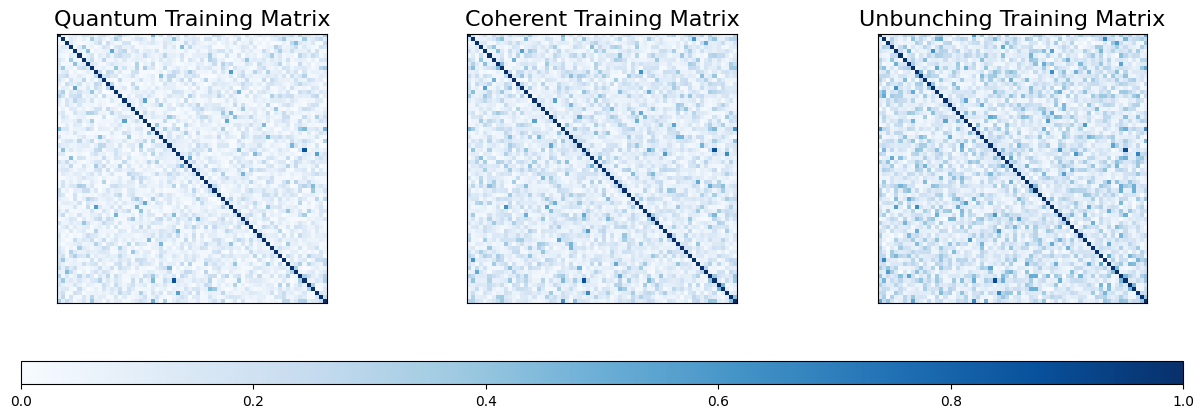

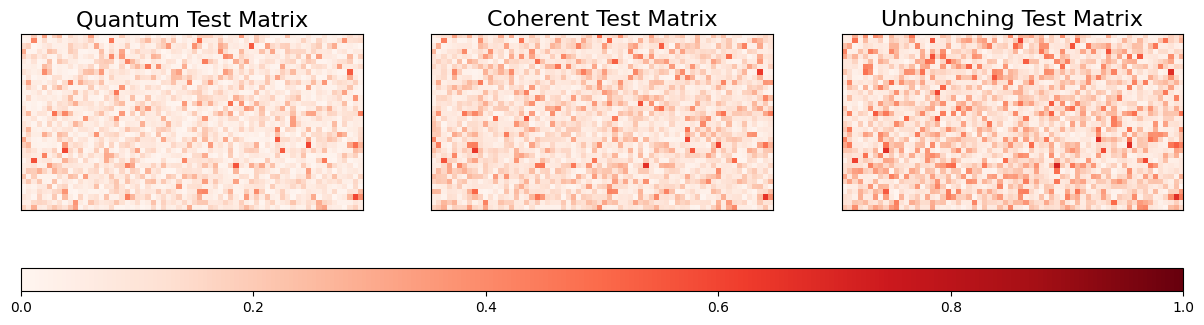

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
im1 = ax1.imshow(K_Q_train, cmap='Blues', vmin=0, vmax=1)
ax1.set_title('Quantum Training Matrix', fontsize=16)
ax1.set_xticks([])
ax1.set_yticks([])

# Plot Coherent training matrix
im2 = ax2.imshow(K_C_train, cmap='Blues', vmin=0, vmax=1)
ax2.set_title('Coherent Training Matrix', fontsize=16)
ax2.set_xticks([])
ax2.set_yticks([])

im3 = ax3.imshow(K_U_train, cmap='Blues', vmin=0, vmax=1)
ax3.set_title('Unbunching Training Matrix', fontsize=16)
ax3.set_xticks([])
ax3.set_yticks([])

cbar = fig.colorbar(im1, ax=[ax1, ax2, ax3], orientation='horizontal', location='bottom', aspect=50)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
im1 = ax1.imshow(K_Q_test, cmap='Reds', vmin=0, vmax=1)
ax1.set_title('Quantum Test Matrix', fontsize=16)
ax1.set_xticks([])
ax1.set_yticks([])

# Plot Coherent training matrix
im2 = ax2.imshow(K_C_test, cmap='Reds', vmin=0, vmax=1)
ax2.set_title('Coherent Test Matrix', fontsize=16)
ax2.set_xticks([])
ax2.set_yticks([])

im3 = ax3.imshow(K_U_test, cmap='Reds', vmin=0, vmax=1)
ax3.set_title('Unbunching Test Matrix', fontsize=16)
ax3.set_xticks([])
ax3.set_yticks([])

cbar = fig.colorbar(im1, ax=[ax1, ax2, ax3], orientation='horizontal', location='bottom', aspect=50)

Let's fit SVC models with our training and test data for the three different kernels. We will also consider the completely classical Gaussian kernel for which, we will perform cross-validation to maximise its performance.

In [12]:
# Train SVC with quantum matrix
model_Q = SVC(kernel='precomputed')
model_Q.fit(K_Q_train, y_train)
print('The SVC training accuracy using the quantum kernel', model_Q.score(K_Q_train, y_train))
print('The SVC test accuracy using the quantum kernel', model_Q.score(K_Q_train, y_train), '\n')

# Train SVC with coherent matrix
model_C = SVC(kernel='precomputed')
model_C.fit(K_C_train, y_train)
accuracy_C = model_C.score(K_C_test, y_test)
print('The SVC training accuracy using the coherent kernel', model_C.score(K_C_train, y_train))
print('The SVC test accuracy using the coherent kernel', accuracy_C, '\n')

# Train SVC with unbunching matrix
model_U = SVC(kernel='precomputed')
model_U.fit(K_U_train, y_train)
accuracy_U = model_C.score(K_U_test, y_test)
print('The SVC training accuracy using the unbunching kernel', model_U.score(K_U_train, y_train))
print('The SVC test accuracy using the unbunching kernel', accuracy_U, '\n')

# Gaussian kernel
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
accuracy_G = grid_search.best_estimator_.score(X_test, y_test)
print('The SVC training accuracy using the Gaussian kernel', best_model.score(X_train, y_train))
print('The SVC test accuracy using the Gaussian kernel', best_model.score(X_test, y_test))

The SVC training accuracy using the quantum kernel 1.0
The SVC test accuracy using the quantum kernel 1.0 

The SVC training accuracy using the coherent kernel 0.9696969696969697
The SVC test accuracy using the coherent kernel 0.6176470588235294 

The SVC training accuracy using the unbunching kernel 0.9696969696969697
The SVC test accuracy using the unbunching kernel 0.8823529411764706 

The SVC training accuracy using the Gaussian kernel 0.5303030303030303
The SVC test accuracy using the Gaussian kernel 0.4411764705882353


### Plotting Training Curves

We will investigate the performance of the different kernels by plotting the test set accuracy versus the training set size.

In [13]:
# Different training set sizes
data_sizes = np.arange(20, N, 10)

# Lists to contain accuracy for each kernel
accuracies_Q = []
accuracies_C = []
accuracies_U = []
accuracies_G = []

for size in data_sizes:
    accuracy_sublist_Q = []
    accuracy_sublist_C = []
    accuracy_sublist_U = []
    accuracy_sublist_G = []
    
    for rep in range(10): 
        # Generate indices for Train test split
        np.random.shuffle(indices)
        train_indices = indices[:size]
        test_indices = indices[-10:] # Constant test set of size 10
        
        # Train test split 
        K_Q_train = np.array([[K_Q[i, j] for j in train_indices] for i in train_indices])
        K_Q_test =  np.array([[K_Q[i, j] for j in train_indices] for i in test_indices])
        K_C_train = np.array([[K_C[i, j] for j in train_indices] for i in train_indices])
        K_C_test =  np.array([[K_C[i, j] for j in train_indices] for i in test_indices])
        K_U_train = np.array([[K_U[i, j] for j in train_indices] for i in train_indices])
        K_U_test =  np.array([[K_U[i, j] for j in train_indices] for i in test_indices])
        
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        # Fit model with quantum kernel
        model_Q = SVC(kernel='precomputed')
        model_Q.fit(K_Q_train, y_train)
        accuracy_sublist_Q.append(model_Q.score(K_Q_test, y_test))
        
        # Fit model with coherent kernel
        model_C = SVC(kernel='precomputed')
        model_C.fit(K_C_train, y_train)
        accuracy_sublist_C.append(model_C.score(K_C_test, y_test))
        
        # Fit model with unbunching kernel
        model_U = SVC(kernel='precomputed')
        model_U.fit(K_U_train, y_train)
        accuracy_sublist_U.append(model_U.score(K_U_test, y_test))
        
        # Cross-validation grid search to obtain optimal gaussian kernel
        grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=4, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        accuracy_sublist_G.append(best_model.score(X[test_indices], y_test))
    
    accuracies_Q.append(accuracy_sublist_Q)
    accuracies_C.append(accuracy_sublist_C)
    accuracies_U.append(accuracy_sublist_U)
    accuracies_G.append(accuracy_sublist_G)

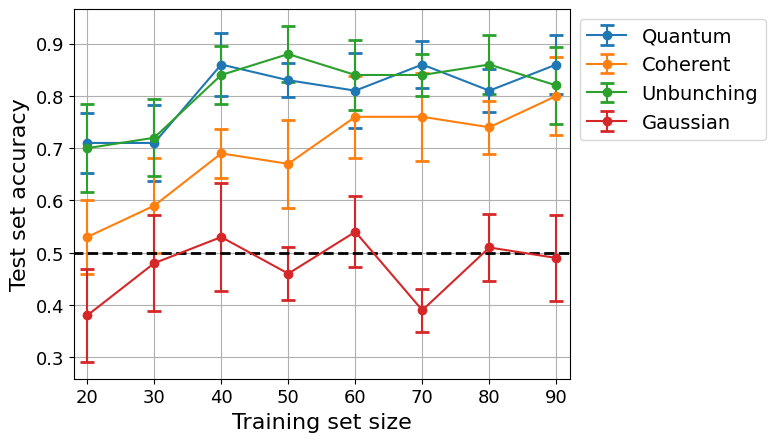

In [14]:
# Calculate means and standard deviations
mean_accuracies_Q = [np.mean(sublist) for sublist in accuracies_Q]
std_Q = np.array([np.std(sublist) for sublist in accuracies_Q])

mean_accuracies_C = [np.mean(sublist) for sublist in accuracies_C]
std_C = np.array([np.std(sublist) for sublist in accuracies_C])

mean_accuracies_U = [np.mean(sublist) for sublist in accuracies_U]
std_U = np.array([np.std(sublist) for sublist in accuracies_U])

mean_accuracies_G = [np.mean(sublist) for sublist in accuracies_G]
std_G = np.array([np.std(sublist) for sublist in accuracies_G])

# Plotting 
plt.errorbar(data_sizes, mean_accuracies_Q, 
            yerr=(std_Q/2, std_Q/2), 
            fmt='-o', 
            capsize=5, 
            capthick=2, 
            ecolor='tab:blue', 
            label='Quantum',
            )
plt.errorbar(data_sizes, mean_accuracies_C, 
            yerr=(std_C/2, std_C/2), 
            fmt='-o', 
            capsize=5, 
            capthick=2, 
            ecolor='tab:orange', 
            label='Coherent',
            )
plt.errorbar(data_sizes, mean_accuracies_U, 
            yerr=(std_U/2, std_U/2),  
            fmt='-o', 
            capsize=5, 
            capthick=2, 
            ecolor='tab:green', 
            label='Unbunching',
            )
plt.errorbar(data_sizes, mean_accuracies_G, 
            yerr=(std_G/2, std_G/2),  
            fmt='-o', 
            capsize=5, 
            capthick=2, 
            ecolor='tab:red', 
            label='Gaussian',
            )
plt.plot([0, N], [0.5, 0.5], c='black', linestyle='dashed', linewidth=2)
plt.xlabel('Training set size', fontsize=16)
plt.ylabel('Test set accuracy', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(18, N - 8)
plt.grid(True)
plt.legend(bbox_to_anchor=[1, 1], fontsize=14)
plt.show()

## References

[1] Z. Yin, I. Agresti, G. de Felice, D. Brown, A. Toumi, C. Pentangelo, S. Piacentini, A. Crespi, F. Ceccarelli, R. Osellame, B. Coecke, and P. Walther, "Experimental quantum-enhanced kernels on a photonic processor," *arXiv*, 2024. [Online]. Available: https://arxiv.org/abs/2407.20364

[2] S. Aaronson and A. Arkhipov, ‘The Computational Complexity of Linear Optics’, Theory of Computing. vol. 9: pp. 143–252, 2013.

[3] M. Jerrum, A. Sinclair, and E. Vigoda, ‘A polynomial-time approximation algorithm for the permanent of a matrix with nonnegative entries’, J. ACM, vol. 51, no. 4, pp. 671–697, 2004.
